<a href="https://colab.research.google.com/github/saisumedha/Hybrid-forecasting-models-for-financial-datasets/blob/main/hybrid_forecasting_models_for_financial_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing Required Libaries

In [ ]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.7 MB/s eta 0:00:00


In [ ]:
!pip install yfinance

In [ ]:

import pandas as pd
import math
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import random
from datetime import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt


### Getting the historical Data from Yahoo Finance - Apple stocks

In [ ]:
import yfinance as yf
import pandas as pd

start_date = "2020-11-19"
end_date = "2024-10-11"
ticker = 'AAPL'

data = yf.download(ticker, start=start_date, end=end_date, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
print(data.columns)

MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [ ]:
cols = ["Adj_Close", "Close", "High", "Low", "Open", "Volume"]

data.columns = cols

data = data.dropna()

# Set the frequency of the date index
data.index = pd.date_range(start=start_date, periods=len(data), freq='D')

print(f"The Shape of the Data-Set is : {data.shape}\nThe Data-Set is : \n{data.head()}\n")

The Shape of the Data-Set is : (978, 6)
The Data-Set is : 
             Adj_Close       Close        High         Low        Open  \
2020-11-19  116.012726  118.639999  119.059998  116.809998  117.589996   
2020-11-20  114.741493  117.339996  118.769997  117.290001  118.639999   
2020-11-21  111.328773  113.849998  117.620003  113.750000  117.180000   
2020-11-22  112.619568  115.169998  115.849998  112.589996  113.910004   
2020-11-23  113.460510  116.029999  116.750000  115.169998  115.550003   

               Volume  
2020-11-19   74113000  
2020-11-20   73604300  
2020-11-21  127959300  
2020-11-22  113874200  
2020-11-23   76499200  



In [ ]:
data.columns

Index(['Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [ ]:
close = "Adj_Close"

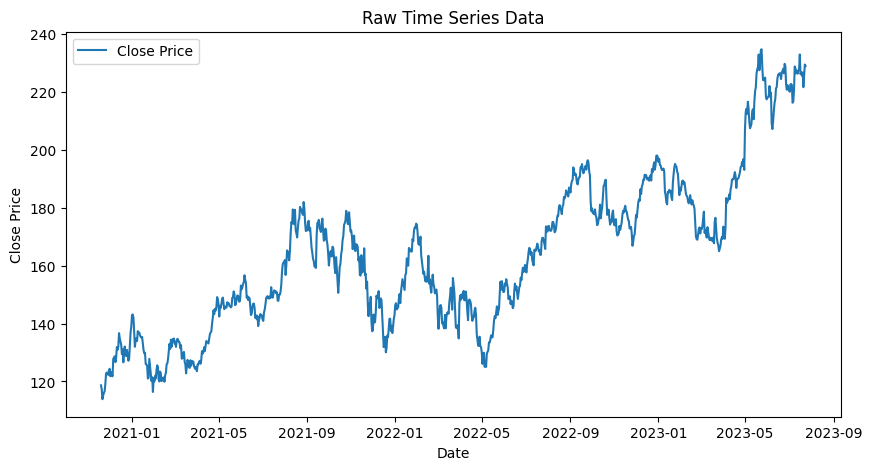

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(data.index, data['Close'], label='Close Price')
plt.title('Raw Time Series Data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

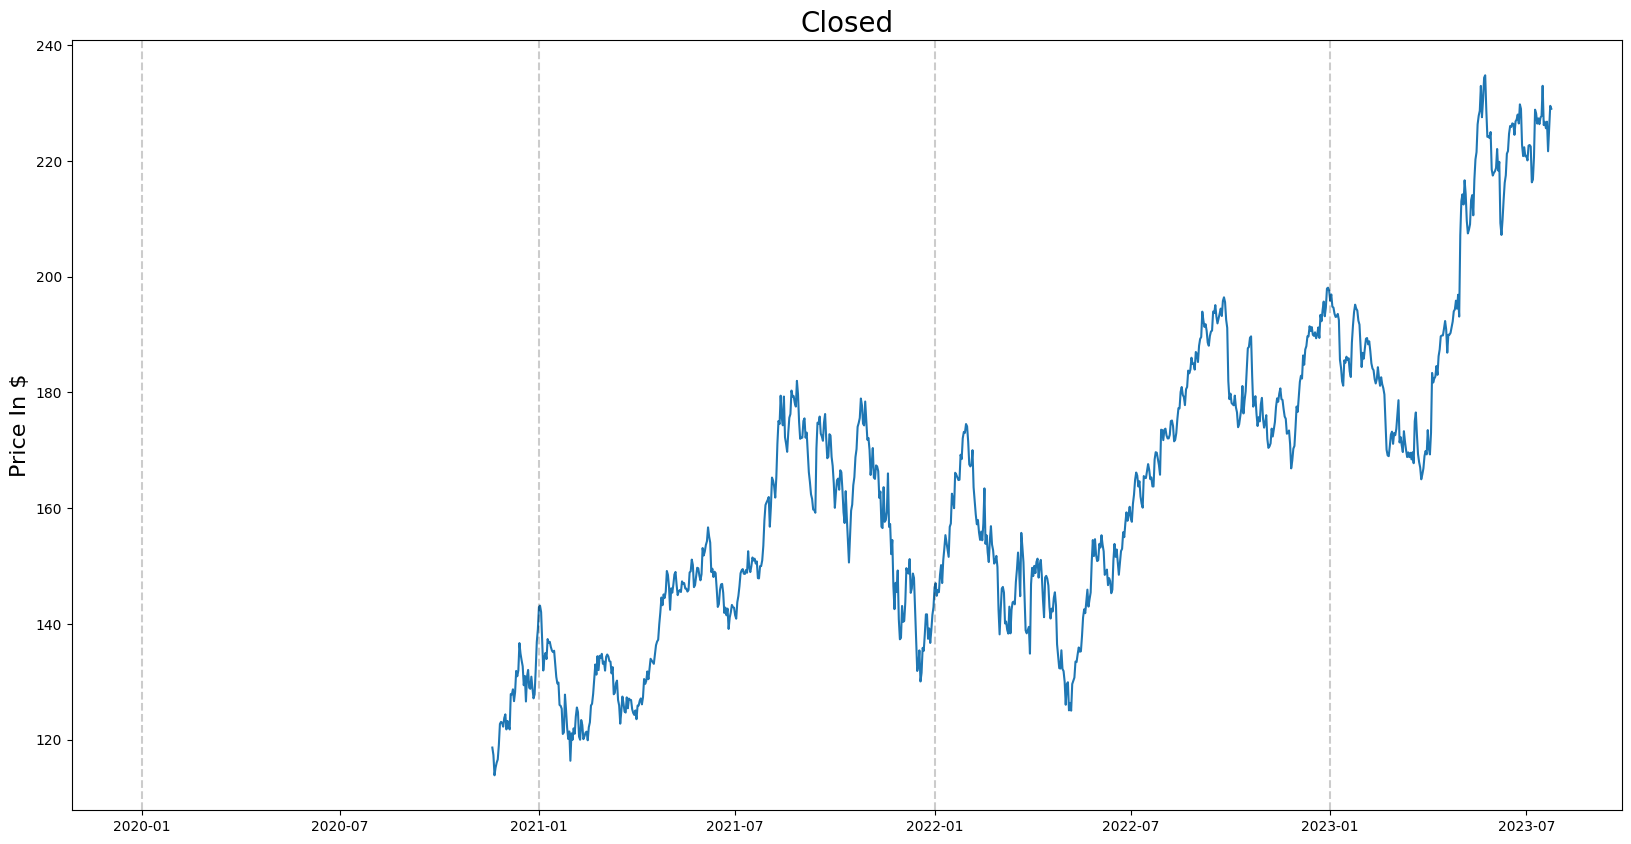

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data.Close)
plt.title('Closed', fontsize=20)
plt.ylabel('Price In $', fontsize=16)
for year in range(2020,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

### Check the stationarity test using Adfuller test

In [ ]:
hypo1 = adfuller(data['Close'])
print("\nDickey-Fuller Test on Raw Data (Close):")
print(f"ADF Statistic: {hypo1[0]}")
print(f"p-value: {hypo1[1]}")
print(f"Critical Values: {hypo1[4]}")



Dickey-Fuller Test on Raw Data (Close):
ADF Statistic: -1.0877995188637337
p-value: 0.7199127115492329
Critical Values: {'1%': -3.43706091543889, '5%': -2.8645028204932483, '10%': -2.568347558984588}


In [ ]:
if hypo1[1] < 0.05:
    print("\nThe time series is stationary (p-value < 0.05).")
else:
    print("\nThe time series is non-stationary (p-value > 0.05).")


The time series is non-stationary (p-value > 0.05).


In [ ]:
data['FirstDifference'] = data['Close'].diff().dropna()
data = data.dropna()

In [ ]:
hypo2 = adfuller(data['FirstDifference'])
print("\nDickey-Fuller Test on First-Differenced Data:")
print(f"ADF Statistic: {hypo2[0]}")
print(f"p-value: {hypo2[1]}")
print(f"Critical Values: {hypo2[4]}")


Dickey-Fuller Test on First-Differenced Data:
ADF Statistic: -30.78174562839029
p-value: 0.0
Critical Values: {'1%': -3.4370678095881804, '5%': -2.8645058608075264, '10%': -2.568349178354273}


In [ ]:
if hypo2[1] < 0.05:
    print("\nThe first-differenced series is stationary (p-value < 0.05).")
else:
    print("\nThe first-differenced series is still non-stationary (p-value > 0.05).")


The first-differenced series is stationary (p-value < 0.05).


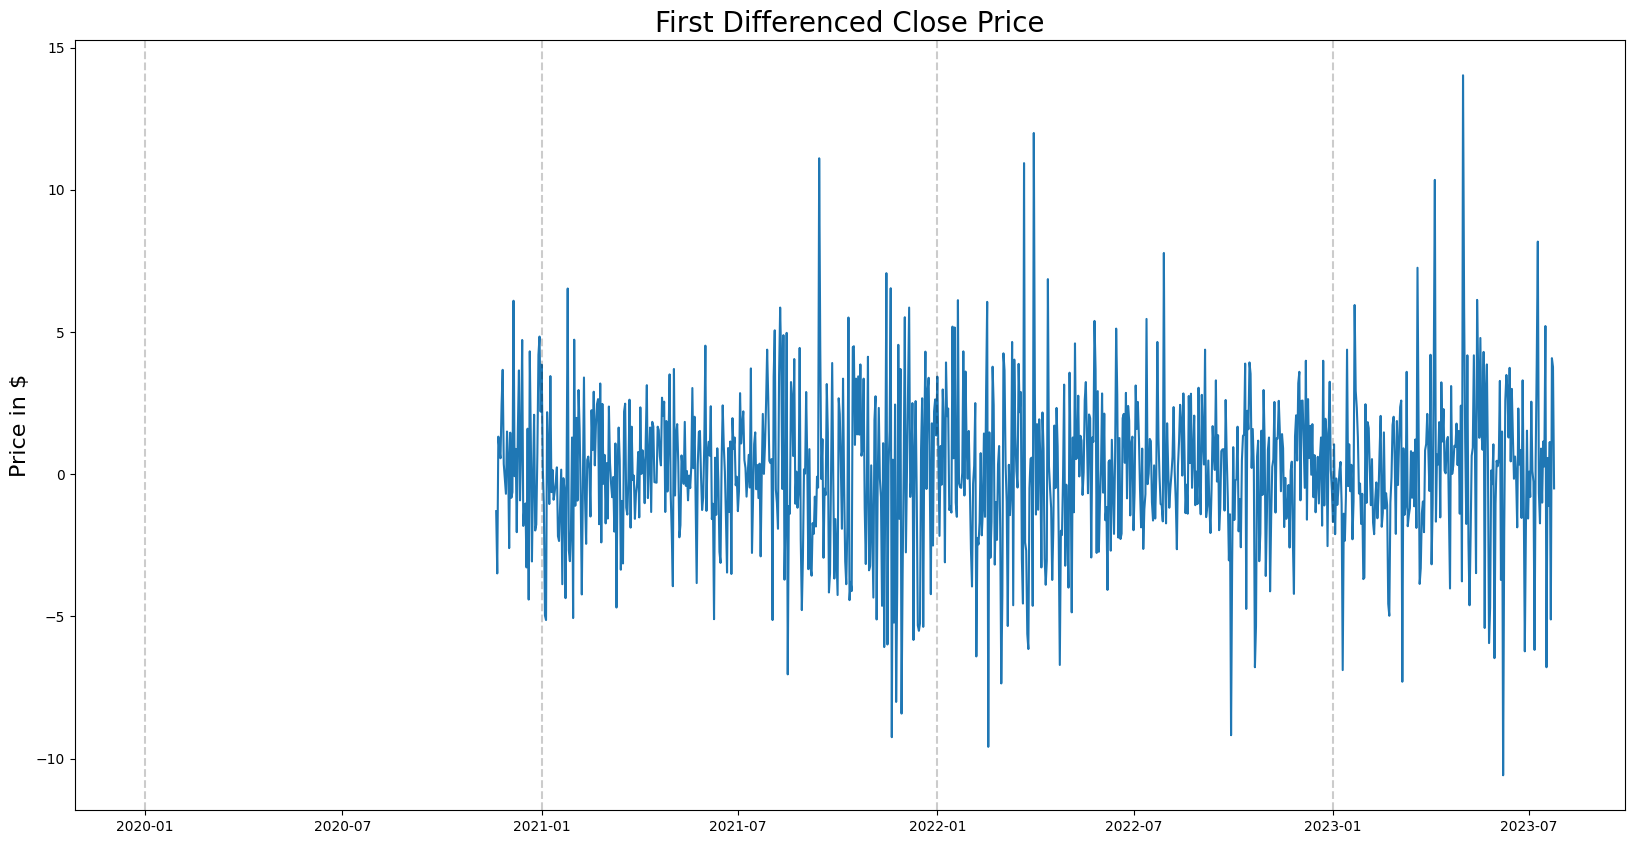

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(data['FirstDifference'])
plt.title('First Differenced Close Price', fontsize=20)
plt.ylabel('Price in $', fontsize=16)
for year in range(2020, 2024):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

### Making it Stationary using ARIMA

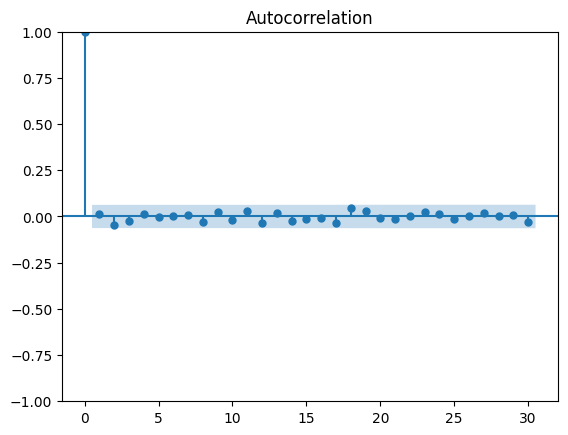

In [ ]:
plot_acf(data.FirstDifference)
plt.show()

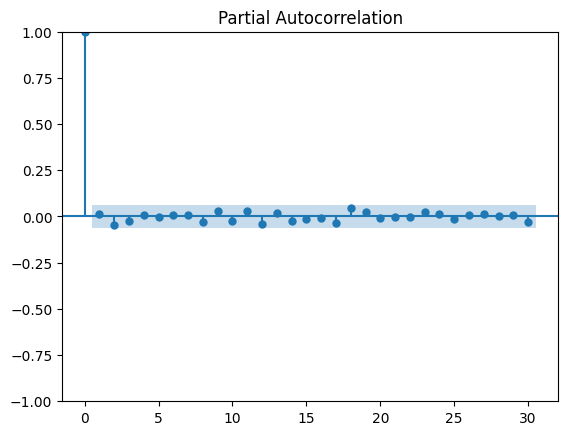

In [ ]:
plot_pacf(data.FirstDifference)
plt.show()

In [ ]:
model = ARIMA(data['FirstDifference'].dropna(), order=(0, 0, 0))  # ARIMA(p,d,q) model
result = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
fvalues = result.fittedvalues
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        FirstDifference   No. Observations:                  976
Model:                          ARIMA   Log Likelihood              -20958.535
Date:                Sun, 01 Dec 2024   AIC                          41921.069
Time:                        17:39:19   BIC                          41930.836
Sample:                             0   HQIC                         41924.786
                                - 976                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.654e+04   8.45e+08  -5.51e-05      1.000   -1.66e+09    1.66e+09
sigma2      7.135e+17      0.001   7.83e+20      0.000    7.13e+17    7.13e+17
===================================================================================
Ljung-Box (L1) (Q):                 109.39   Jarque-Bera (JB):             16694.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.06
Prob(H) (two-sided):                  0.02   Kurtosis:                        23.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [ ]:
residual = data['FirstDifference'].dropna() - fvalues
residual_cumsum = residual.cumsum()

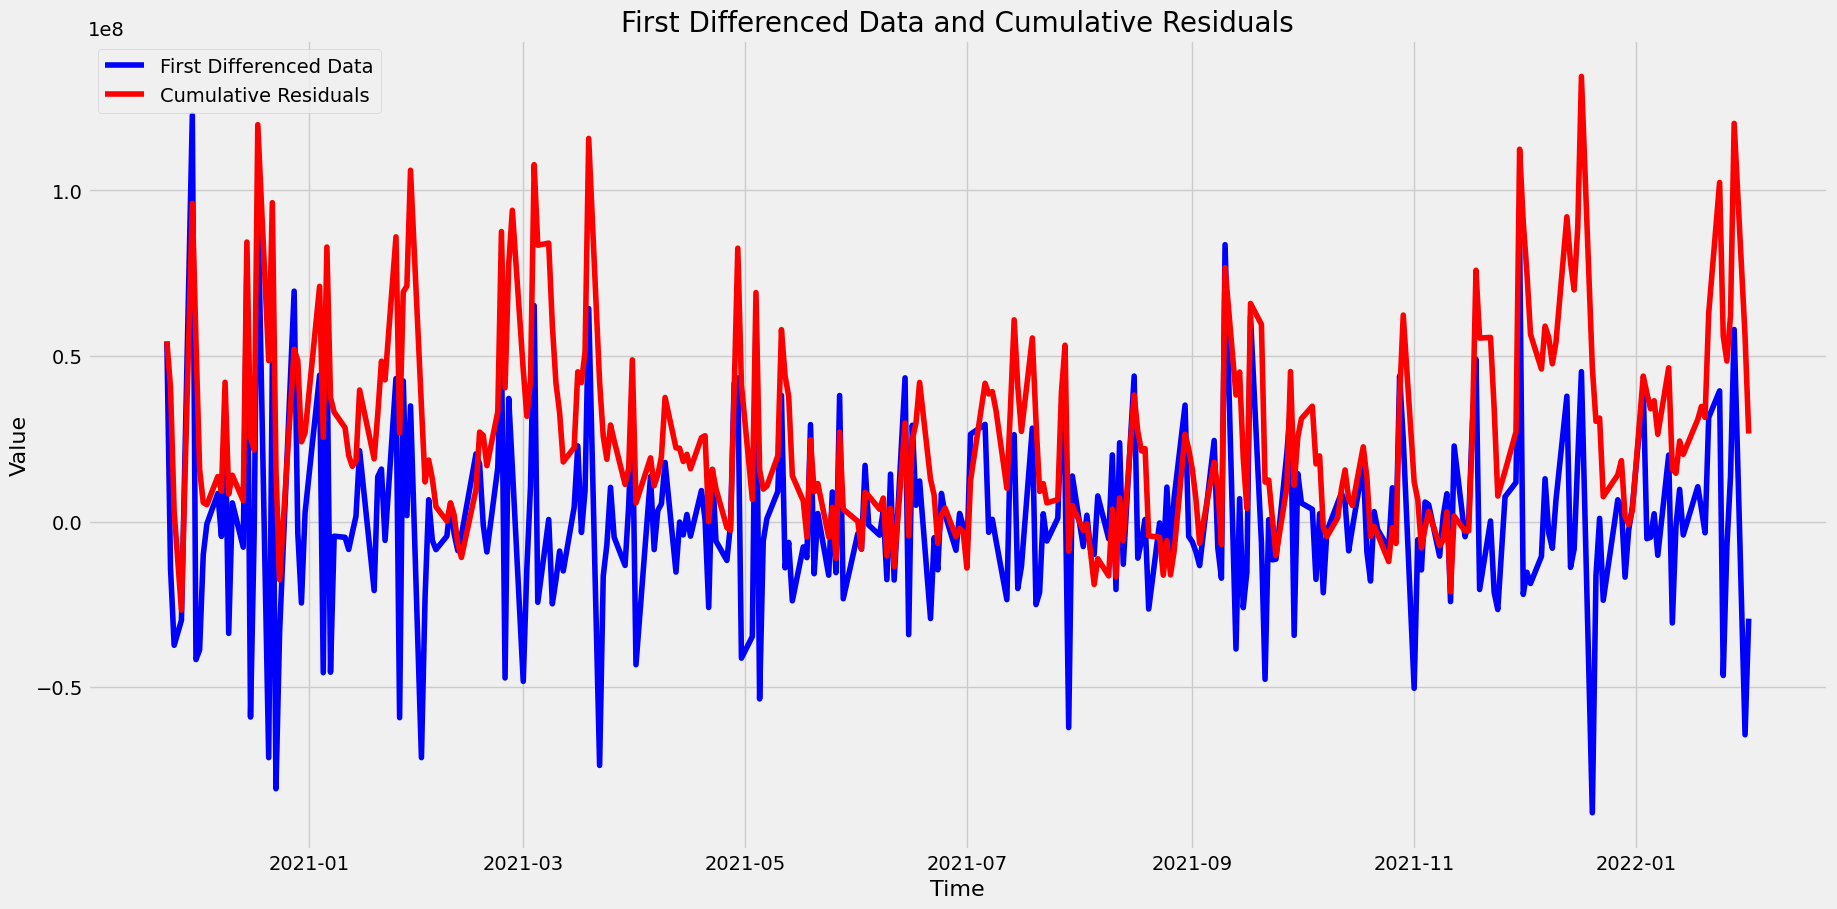

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(data['FirstDifference'][:300], label='First Differenced Data', color='blue')
plt.plot(residual_cumsum[:300], label='Cumulative Residuals', color='red')
plt.title('First Differenced Data and Cumulative Residuals', fontsize=20)
plt.ylabel('Value', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.legend(loc='best')
plt.show()

### Forecasting Arima Model

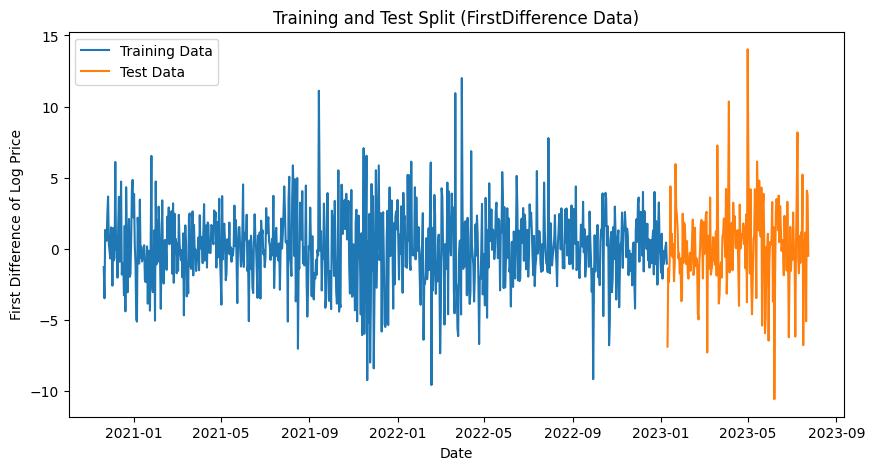

In [ ]:
train_size = int(len(data['FirstDifference']) * 0.8)  # 80% for training
train_diff, test_diff = data['FirstDifference'][:train_size], data['FirstDifference'][train_size:]

# Plot the split data
plt.figure(figsize=(10, 5))
plt.plot(train_diff, label='Training Data')
plt.plot(test_diff, label='Test Data')
plt.title('Training and Test Split (FirstDifference Data)')
plt.xlabel('Date')
plt.ylabel('First Difference of Log Price')
plt.legend()
plt.show()

### Doing Auto ARIMA to get best P,Q,D Values

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.8 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm
import statsmodels.api as sm
auto_arima_model = pm.auto_arima(train_diff, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3743.878, Time=1.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3738.117, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3740.114, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3740.113, Time=1.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3741.667, Time=3.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3739.117, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 5.781 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  781
Model:                        SARIMAX   Log Likelihood               -1868.058
Date:                Sun, 01 Dec 2024   AIC                           3738.117
Time:                        16:50:56   BIC                           3742.777
Sample:                    11-20-2020   HQIC                          3739.909
          

In [ ]:
optimal_order = auto_arima_model.order

In [ ]:
model = sm.tsa.ARIMA(train_diff, order=optimal_order)
model_fit = model.fit()

In [ ]:
start_index = len(train_diff)
end_index = len(train_diff) + len(test_diff) - 1
forecast_diff = model_fit.predict(start=start_index, end=end_index, typ='levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
forecast_cumsum = forecast_diff.cumsum()
forecast_series = data['Close'].iloc[train_size - 1] + forecast_cumsum

In [ ]:
forecast_series.index = data.index[train_size:]

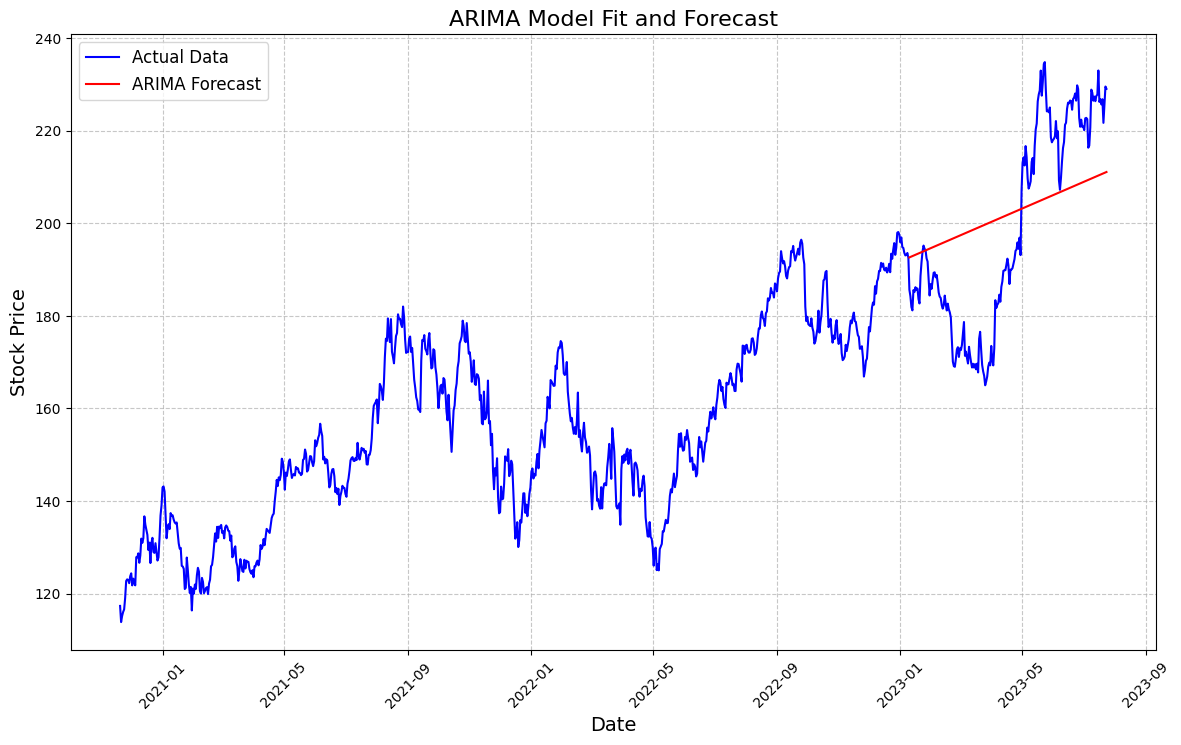

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(data['Close'], label='Actual Data', color='blue', linewidth=1.5)
plt.plot(forecast_series.index, forecast_series, label='ARIMA Forecast', color='red', linewidth=1.5)
plt.title('ARIMA Model Fit and Forecast', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

In [ ]:
if len(data['Close'][train_size:]) > len(forecast_series):
    actual_test = data['Close'][train_size:train_size+len(forecast_series)]
else:
    actual_test = data['Close'][train_size:]

rmse = np.sqrt(mean_squared_error(actual_test, forecast_series))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 17.962735472708136


### Using Auto Arima inputs running it normally


In [ ]:
arima_order = (0, 0, 0)
model = sm.tsa.ARIMA(train_diff, order=arima_order)
model_fit = model.fit()

In [ ]:
start_index = len(train_diff)
end_index = len(train_diff) + len(test_diff) - 1
forecast = model_fit.predict(start=start_index, end=end_index, typ='levels')

In [ ]:
forecast_cumsum = forecast.cumsum()
forecast_series = data['Close'].iloc[train_size - 1] + forecast_cumsum

forecast_series.index = data.index[train_size:]

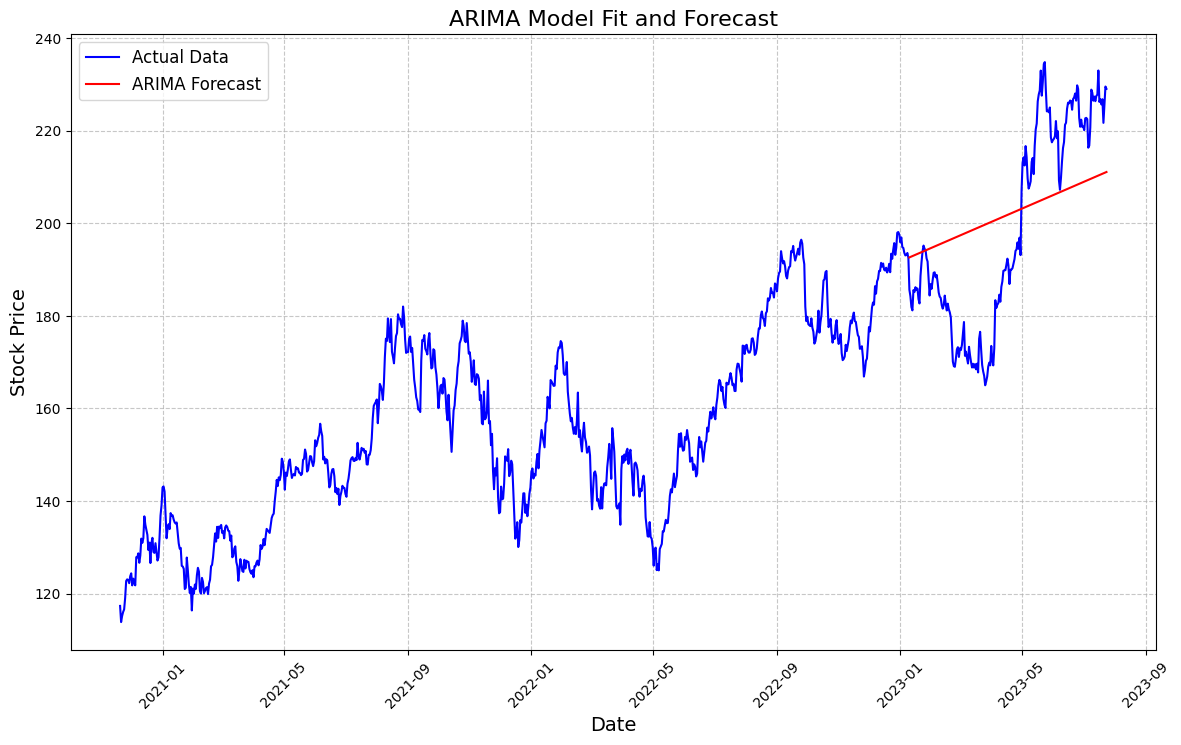

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(data['Close'], label='Actual Data', color='blue', linewidth=1.5)
plt.plot(forecast_series.index, forecast_series, label='ARIMA Forecast', color='red', linewidth=1.5)
plt.title('ARIMA Model Fit and Forecast', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()



In [ ]:
if len(data['Close'][train_size:]) > len(forecast_series):
    actual_test = data['Close'][train_size:train_size+len(forecast_series)]
else:
    actual_test = data['Close'][train_size:]

rmse = np.sqrt(mean_squared_error(actual_test, forecast_series))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 17.962735472708136


In [ ]:
from sklearn.metrics import mean_squared_error

# Ensure both series have the same length
if len(data['Close'][train_size:]) > len(forecast_series):
    actual_test = data['Close'][train_size:train_size+len(forecast_series)]
else:
    actual_test = data['Close'][train_size:]

# Calculate MSE
mse = mean_squared_error(actual_test, forecast_series)
print(f'Mean Squared Error: {mse}')


NameError: name 'data' is not defined



---



### LSTM

In [ ]:
import pandas
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
import yfinance as yf
import pandas as pd

start_date = "2020-11-19"
end_date = "2024-10-11"
ticker = 'AAPL'

df = yf.download(ticker, start=start_date, end=end_date, interval='1d')

cols = ["Adj_Close", "Close", "High", "Low", "Open", "Volume"]

df.columns = cols

df = df.dropna()

print(f"The Shape of the Data-Set is : {data.shape}\nThe Data-Set is : \n{data.head()}\n")

[*********************100%***********************]  1 of 1 completed

The Shape of the Data-Set is : (977, 7)
The Data-Set is : 
             Adj_Close       Close        High         Low        Open  \
2020-11-20  114.741493  117.339996  118.769997  117.290001  118.639999   
2020-11-21  111.328773  113.849998  117.620003  113.750000  117.180000   
2020-11-22  112.619568  115.169998  115.849998  112.589996  113.910004   
2020-11-23  113.460510  116.029999  116.750000  115.169998  115.550003   
2020-11-24  114.008118  116.589996  117.489998  116.220001  116.570000   

               Volume  FirstDifference  
2020-11-20   73604300        -1.300003  
2020-11-21  127959300        -3.489998  
2020-11-22  113874200         1.320000  
2020-11-23   76499200         0.860001  
2020-11-24   46691300         0.559998  



In [ ]:
df_10 = pd.DataFrame()
df_10['Close'] = df['Close'].rolling(window=10).mean()
df_20 = pd.DataFrame()
df_20['Close'] = df['Close'].rolling(window=20).mean()
df_30 = pd.DataFrame()
df_30['Close'] = df['Close'].rolling(window=30).mean()
df_40 = pd.DataFrame()
df_40['Close'] = df['Close'].rolling(window=40).mean()

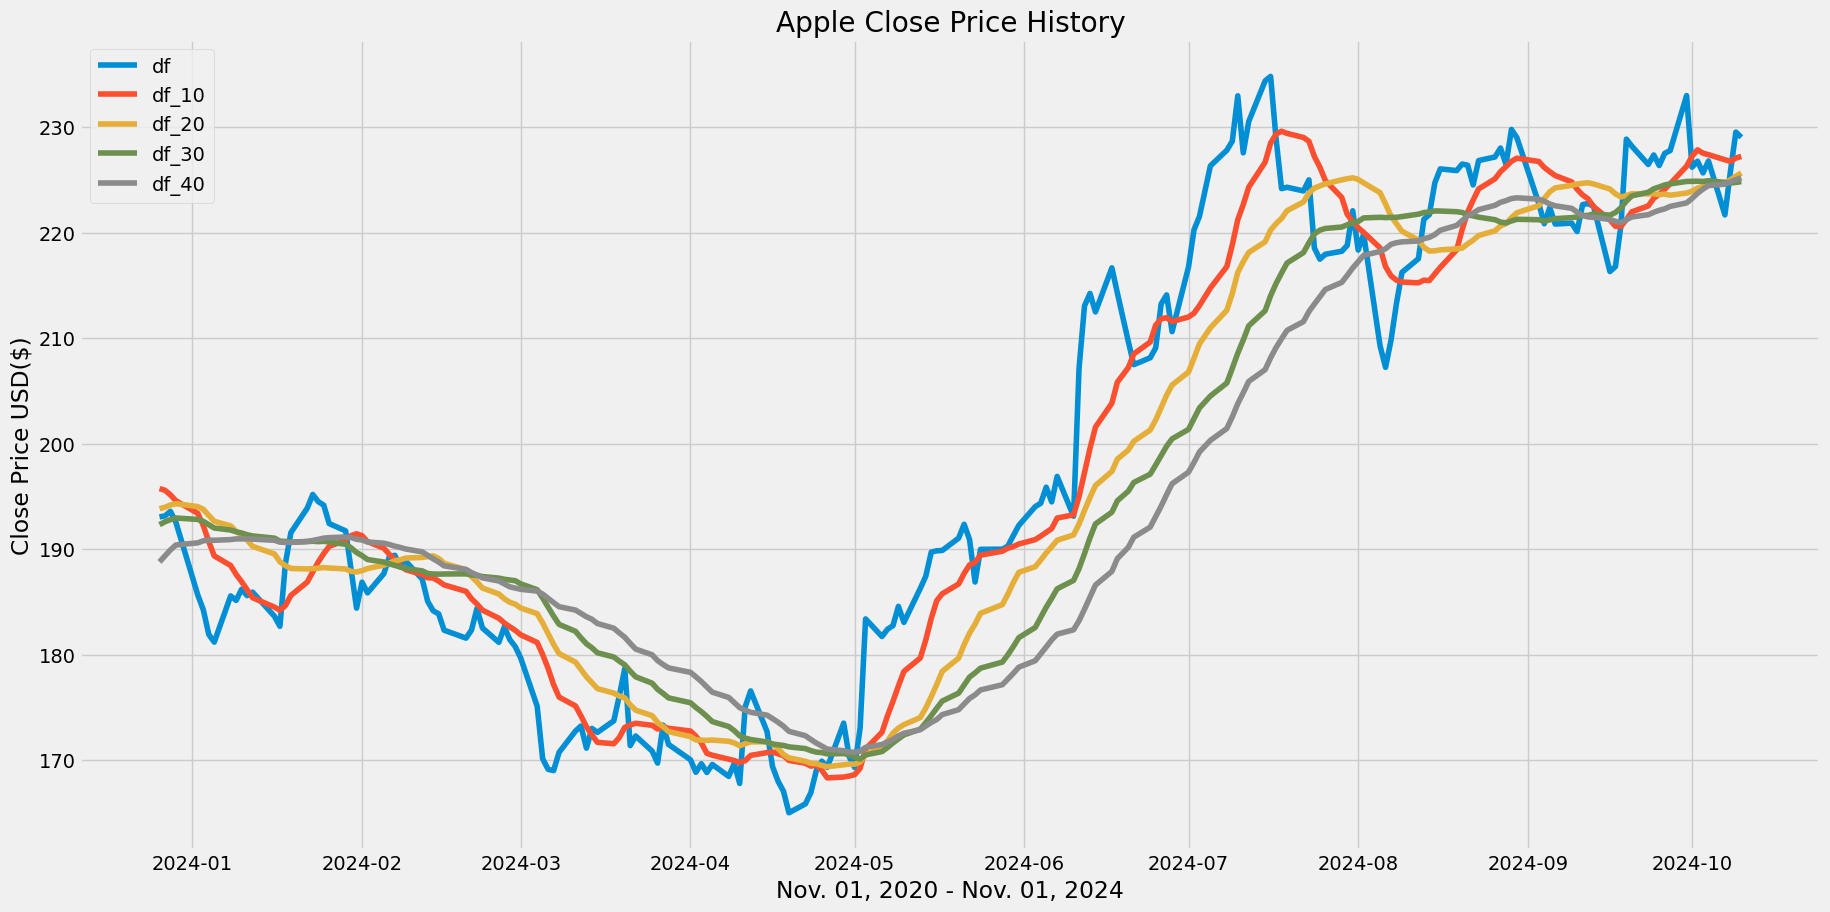

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df['Close'].tail(200), label='df')
plt.plot(df_10['Close'].tail(200), label='df_10')
plt.plot(df_20['Close'].tail(200), label='df_20')
plt.plot(df_30['Close'].tail(200), label='df_30')
plt.plot(df_40['Close'].tail(200), label='df_40')
plt.title('Apple Close Price History')
plt.xlabel('Nov. 01, 2020 - Nov. 01, 2024')
plt.ylabel('Close Price USD($)')
plt.legend(loc='upper left')
plt.show()

In [ ]:
a = data['Close'] - data['FirstDifference']
diff_results = residual_cumsum + residual_cumsum.shift(-1)
diff_results = diff_results + a

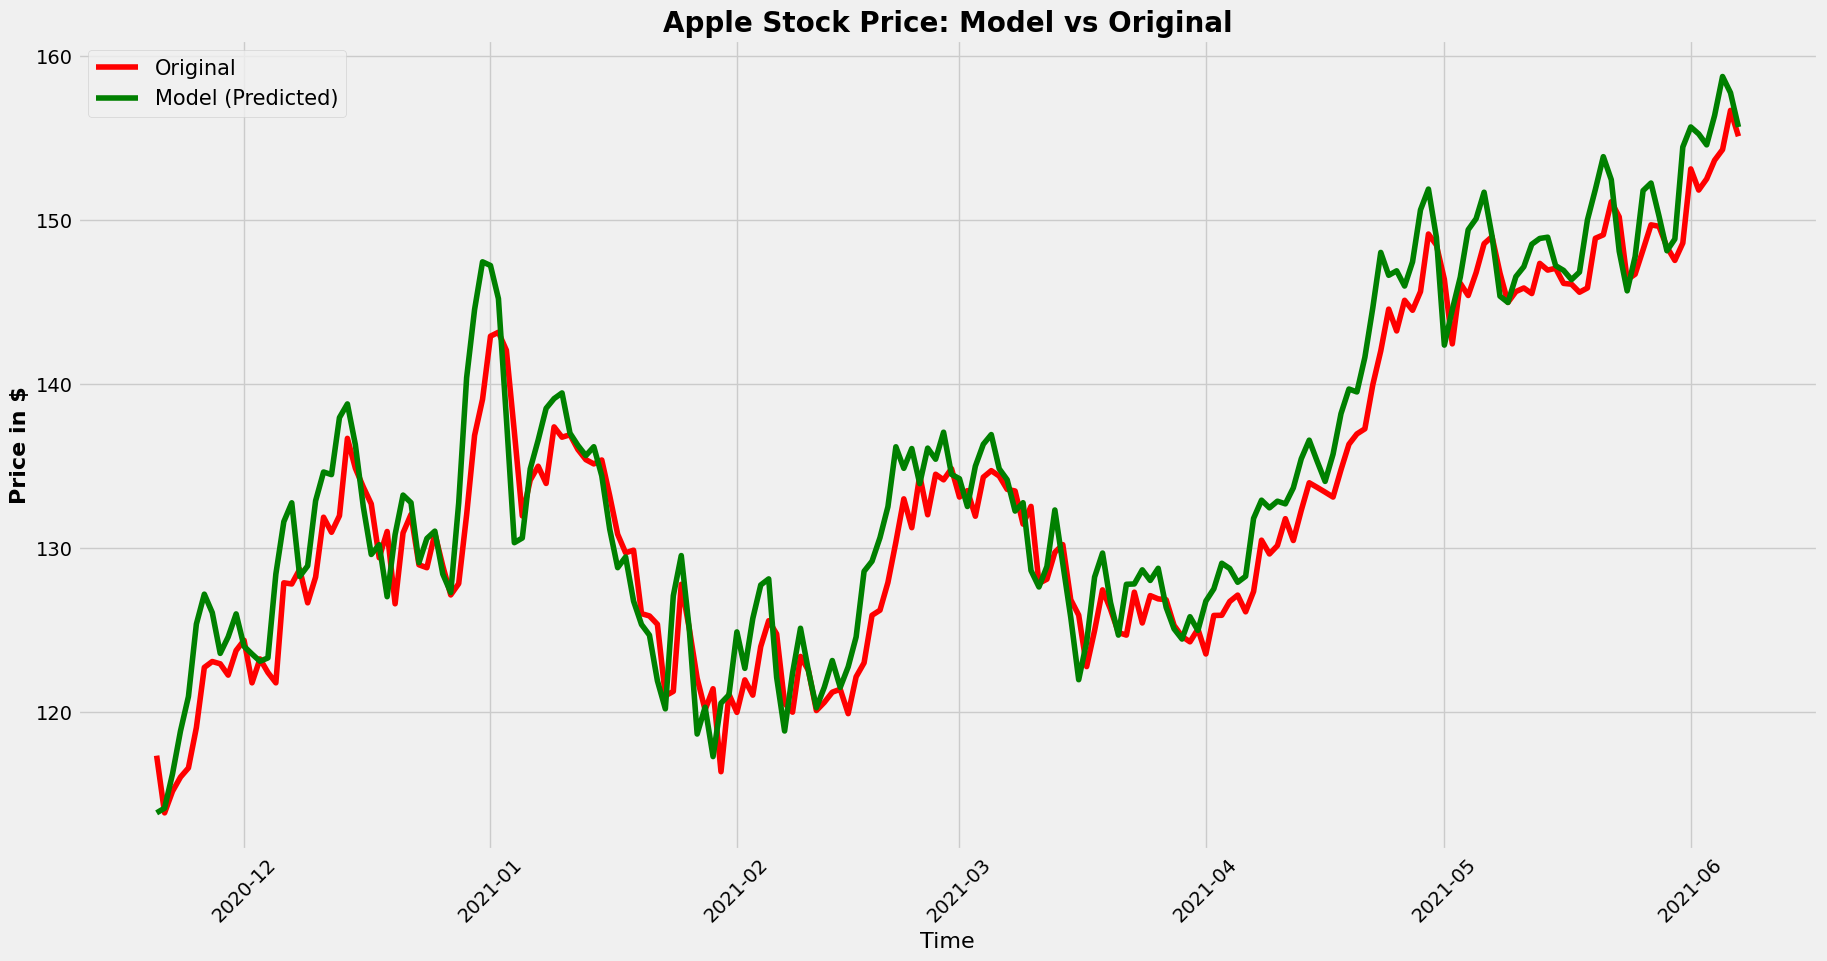

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(data['Close'][:200], label='Original', color='red')
plt.plot(diff_results[:200], label='Model (Predicted)', color='green')
plt.title('Apple Stock Price: Model vs Original', fontweight='bold', fontsize=20)
plt.ylabel('Price in $', fontweight='bold', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.xticks(rotation=45)
plt.legend(prop={'size': 15})
plt.show()

In [ ]:
data = df.filter(['Close'])
data.head()

,Close
Date,
2020-11-19 00:00:00+00:00,118.639999
2020-11-20 00:00:00+00:00,117.339996
2020-11-23 00:00:00+00:00,113.849998
2020-11-24 00:00:00+00:00,115.169998
2020-11-25 00:00:00+00:00,116.029999


In [ ]:
dataset = data.values

In [ ]:
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

783

In [ ]:
scaler = MinMaxScaler()#feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data, scaled_data.shape

(array([[0.0395966 ],
        [0.02885011],
        [0.        ],
        [0.01091179],
        [0.018021  ],
        [0.02265022],
        [0.0429859 ],
        [0.07332398],
        [0.07629993],
        [0.07514262],
        [0.06943871],
        [0.08183848],
        [0.08704636],
        [0.06555344],
        [0.07762254],
        [0.07076138],
        [0.06555344],
        [0.11597915],
        [0.1154005 ],
        [0.12275769],
        [0.10589406],
        [0.11887242],
        [0.14904526],
        [0.14144008],
        [0.14978922],
        [0.18880716],
        [0.17376205],
        [0.16425561],
        [0.15574111],
        [0.12862697],
        [0.14185331],
        [0.10539802],
        [0.14110935],
        [0.15045055],
        [0.1250723 ],
        [0.12358439],
        [0.14086137],
        [0.12449371],
        [0.10986195],
        [0.11556586],
        [0.15028519],
        [0.19029507],
        [0.2084815 ],
        [0.24030749],
        [0.2422915 ],
        [0

In [ ]:
train_data = scaled_data[0:training_data_len,:]

x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=61:
    print(x_train)
    print(y_train)
    print()
print(len(x_train))
print(len(y_train))

[array([0.0395966 , 0.02885011, 0.        , 0.01091179, 0.018021  ,
       0.02265022, 0.0429859 , 0.07332398, 0.07629993, 0.07514262,
       0.06943871, 0.08183848, 0.08704636, 0.06555344, 0.07762254,
       0.07076138, 0.06555344, 0.11597915, 0.1154005 , 0.12275769,
       0.10589406, 0.11887242, 0.14904526, 0.14144008, 0.14978922,
       0.18880716, 0.17376205, 0.16425561, 0.15574111, 0.12862697,
       0.14185331, 0.10539802, 0.14110935, 0.15045055, 0.1250723 ,
       0.12358439, 0.14086137, 0.12449371, 0.10986195, 0.11556586,
       0.15028519, 0.19029507, 0.2084815 , 0.24030749, 0.2422915 ,
       0.23319829, 0.19211372, 0.1497066 , 0.16772753, 0.17475412,
       0.16607425, 0.19459369, 0.18938575, 0.1906258 , 0.18318587,
       0.17806067, 0.17591142, 0.17789531, 0.15987437, 0.14044802])]
[0.13110694452704674]

[array([0.0395966 , 0.02885011, 0.        , 0.01091179, 0.018021  ,
       0.02265022, 0.0429859 , 0.07332398, 0.07629993, 0.07514262,
       0.06943871, 0.08183848, 0.08

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(723, 60, 1)

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(x_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - loss: 0.0053
Epoch 2/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - loss: 0.0014
Epoch 3/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - loss: 0.0011
Epoch 4/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - loss: 9.3713e-04
Epoch 5/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - loss: 8.1595e-04
Epoch 6/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - loss: 9.1979e-04
Epoch 7/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 8.0872e-04
Epoch 8/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 6.8590e-04
Epoch 9/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 8.9702e-04
Epoch 10/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - loss: 6.5314e-04
Epoch 11/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 7.2590e-04
Epoch 12/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - loss: 7.4978e-04
Epoch 13/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 6.5892e-04
Epoch 14/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - lo

In [ ]:
test_data = scaled_data[training_data_len-60: , :]

x_test = []
y_test = dataset[training_data_len:, : ]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [ ]:
x_test = np.array(x_test)

In [ ]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


In [ ]:
print(predictions[0:5], y_test[0:5])

[[187.74872]
 [186.65936]
 [183.95999]
 [183.22546]
 [188.03513]] [[184.25      ]
 [181.91000366]
 [181.17999268]
 [185.55999756]
 [185.13999939]]


In [ ]:
mse = np.mean(predictions-y_test)**2
rmse = np.sqrt(np.mean(predictions-y_test)**2)
mse, rmse

(6.598045614383317, 2.5686661157852564)

<ipython-input-72-e1edcefbb439>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


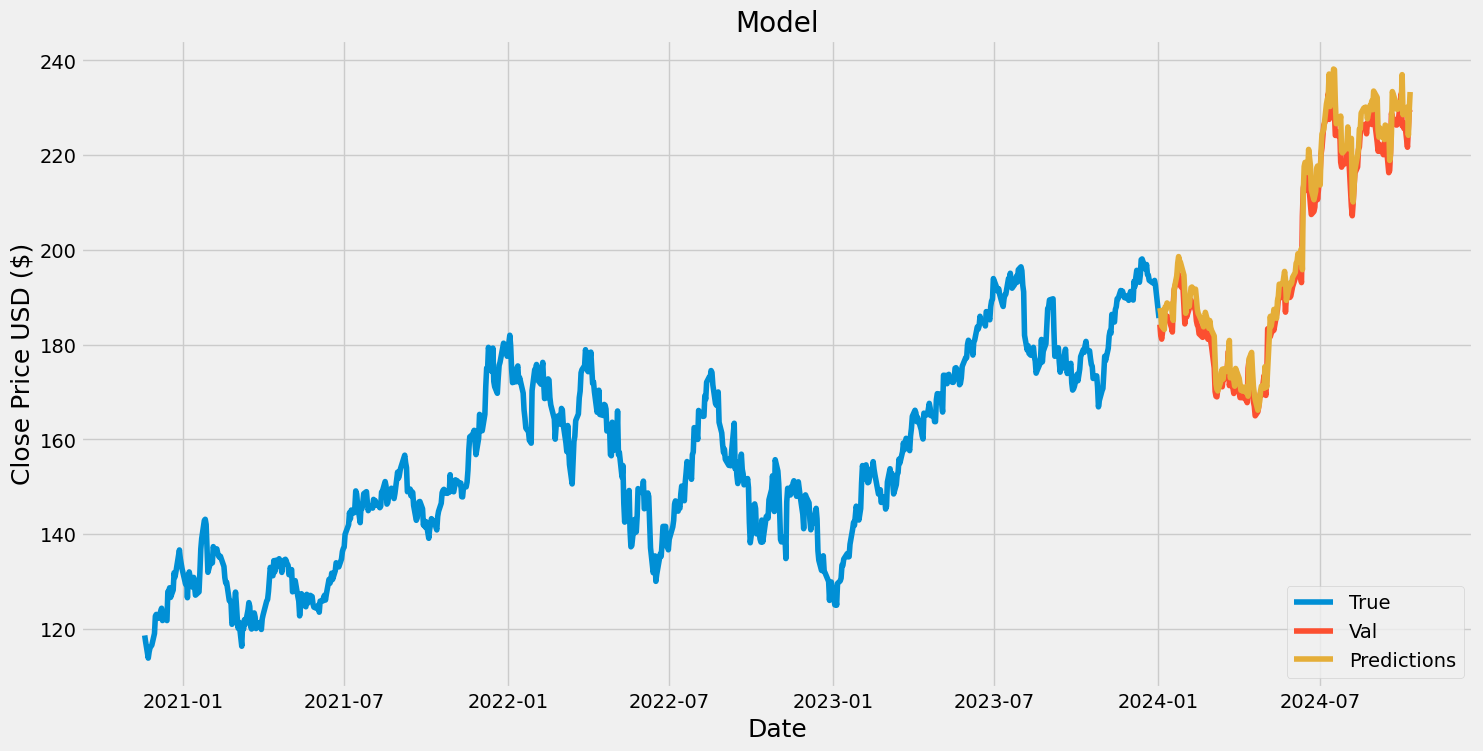

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['True', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

### Hybrid Model

In [ ]:
import yfinance as yf
import pandas as pd

start_date = "2020-11-19"
end_date = "2024-10-11"
ticker = 'AAPL'

data = yf.download(ticker, start=start_date, end=end_date, interval='1d')

cols = ["Adj_Close", "Close", "High", "Low", "Open", "Volume"]

data.columns = cols

data = data.dropna()

print(f"The Shape of the Data-Set is : {data.shape}\nThe Data-Set is : \n{data.head()}\n")

first_diffs = data['Close'] - data['Close'].shift(1)
data['FirstDifference'] = first_diffs
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed

The Shape of the Data-Set is : (978, 6)
The Data-Set is : 
                            Adj_Close       Close        High         Low  \
Date                                                                        
2020-11-19 00:00:00+00:00  116.012726  118.639999  119.059998  116.809998   
2020-11-20 00:00:00+00:00  114.741493  117.339996  118.769997  117.290001   
2020-11-23 00:00:00+00:00  111.328773  113.849998  117.620003  113.750000   
2020-11-24 00:00:00+00:00  112.619568  115.169998  115.849998  112.589996   
2020-11-25 00:00:00+00:00  113.460510  116.029999  116.750000  115.169998   

                                 Open     Volume  
Date                                              
2020-11-19 00:00:00+00:00  117.589996   74113000  
2020-11-20 00:00:00+00:00  118.639999   73604300  
2020-11-23 00:00:00+00:00  117.180000  127959300  
2020-11-24 00:00:00+00:00  113.910004  113874200  
2020-11-25 00:00:00+00:00  115.550003   76499200  



In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM

data['FirstDifference'] = data['Volume'] - data['Volume'].shift(1)
data.dropna(inplace=True)

In [ ]:
arima_model = ARIMA(data['FirstDifference'], order=(0, 0, 0))  # Change ARIMA order based on requirements
arima_result = arima_model.fit()

data['ARIMA_Pred'] = arima_result.fittedvalues.cumsum() + data['Volume'].iloc[0]
data['Residuals'] = data['Volume'] - data['ARIMA_Pred']

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
residual_scaled = scaler.fit_transform(data[['Residuals']])

lookback = 60
X_lstm, y_lstm = [], []
for i in range(lookback, len(residual_scaled)):
    X_lstm.append(residual_scaled[i-lookback:i, 0])
    y_lstm.append(residual_scaled[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

In [ ]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_lstm, y_lstm, epochs=10, batch_size=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


916/916 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 0.0059
Epoch 2/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - loss: 0.0056
Epoch 3/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 0.0052
Epoch 4/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.0051
Epoch 5/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.0107
Epoch 6/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - loss: 0.0053
Epoch 7/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - loss: 0.0054
Epoch 8/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.0048
Epoch 9/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - loss: 0.0056
Epoch 10/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - loss: 0.0058


In [ ]:
lstm_predictions = lstm_model.predict(X_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

data['LSTM_Pred'] = np.concatenate(([0]*lookback, lstm_predictions.flatten()))
data['Hybrid_Pred'] = data['ARIMA_Pred'] + data['LSTM_Pred']

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


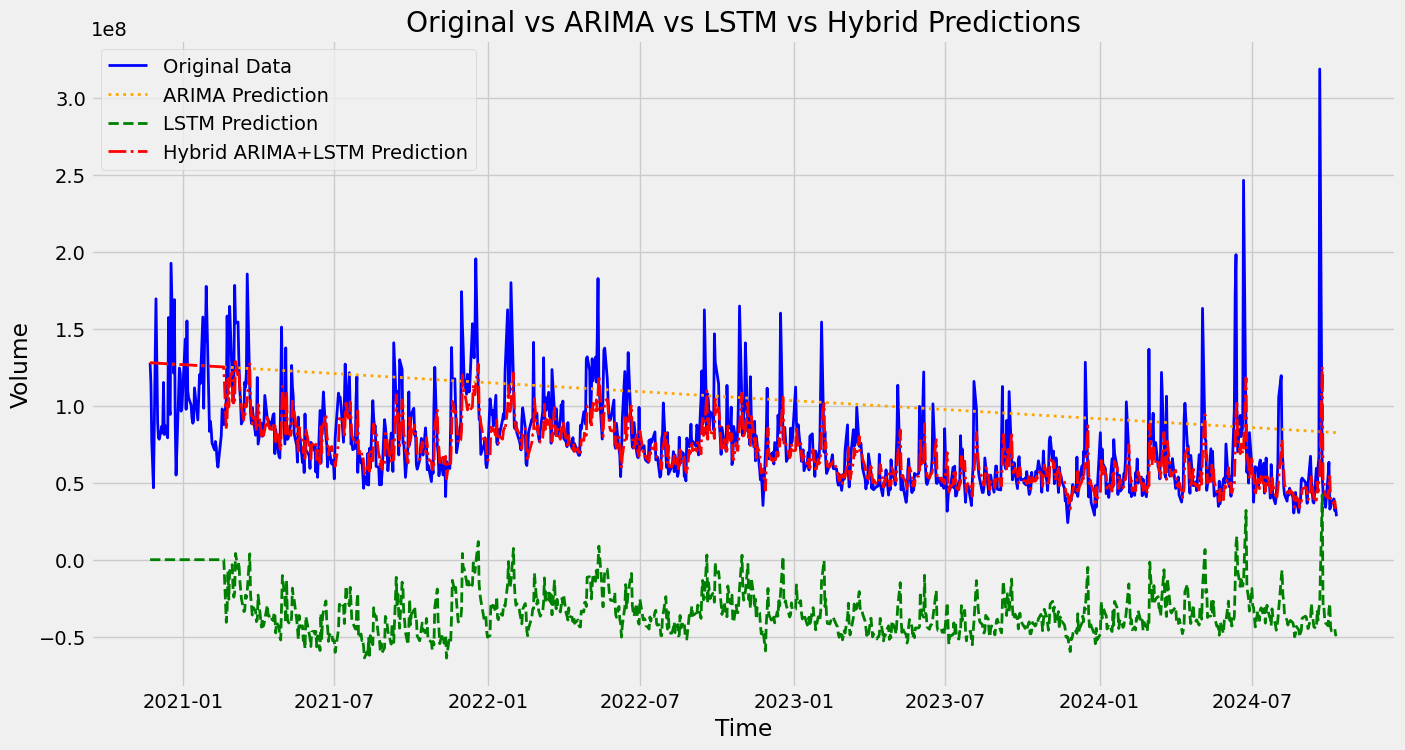

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(data['Volume'], label="Original Data", color='blue', linewidth=2)
plt.plot(data['ARIMA_Pred'], label="ARIMA Prediction", color='orange', linestyle='dotted', linewidth=2)
plt.plot(data['LSTM_Pred'], label="LSTM Prediction", color='green', linestyle='dashed', linewidth=2)
plt.plot(data['Hybrid_Pred'], label="Hybrid ARIMA+LSTM Prediction", color='red', linestyle='dashdot', linewidth=2)
plt.title("Original vs ARIMA vs LSTM vs Hybrid Predictions")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.legend()
plt.show()
